In [254]:
%matplotlib inline

In [255]:
from sklearn import linear_model
import matplotlib.pyplot as plt
import time
import Xlib.display as display
import gtk, pygtk
import csv
import numpy as np
import ConfigParser

In [256]:
#read write project path
#TODO: configure this file according to your path: BehavioralAuthentication/src/main/php/configuration.cfg
config = ConfigParser.RawConfigParser()
config.read('configuration.cfg')

project_dir_path = config.get('Section1', 'project_dir')
resource_path = project_dir_path + "src/test/resources/"

In [257]:
window = gtk.Window()
screen = window.get_screen()

x_size = screen.get_width()
y_size = screen.get_height()

In [356]:
#ted dunning model

def extractFeatures(filename, n_last_timestamps_as_features = 200, normalize = True, bias = True):
    queue = {}
    
    diffTime = {}
    oldTime = -1.0
    
    maxX = 0.0
    
    x_width = float(screen.get_width()) 
    y_width = float(screen.get_height()) 

    i = 1
    with open(filename, 'r') as csvfile:
         spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
         for row in spamreader:
             if (len(row) == 3):
                    
                 timeV = float(row[0])
                
                 if (oldTime == -1):
                    oldTime = timeV
                 else:
                    diffTime[i] = timeV - oldTime
                    oldTime = timeV
                 
                 x = 0.0
                 y = 0.0
                
                 if (normalize):
                     x = float(row[1]) / x_width   
                     y = float(row[2]) / y_width
                 else:    
                     x = row[1]   
                     y = row[2] 

                 queue[i] = (timeV,x,y)  #by order (works only if input is sorted) - maybe by time??
                 i = i + 1


    featureIds = range(1, n_last_timestamps_as_features + 1)

    nFeatures = len(featureIds)*2 # times two because we have two dimensions x and y

    data = np.zeros((i - (max(featureIds)+ 1), nFeatures))
    
       
    target = np.zeros((i - (max(featureIds)+1), 2))

    for o in range(max(featureIds)+1,i):
        for u in range(0,len(featureIds)):
            data[o - max(featureIds) - 1,u*2 + 0] = queue[o - featureIds[u]][1]
            data[o - max(featureIds) - 1,u*2 + 1] = queue[o - featureIds[u]][2]

        target[o - max(featureIds) - 1,0] = queue[o][1]
        target[o - max(featureIds) - 1,1] = queue[o][2]

    
    
    print "mean difference in time step: " + str(np.mean(np.array(diffTime.values())))
    
    print("original shape: " + str(data.shape))
    
    if (bias):
        data = np.hstack((data, np.ones((data.shape[0], 1), dtype=data.dtype)))
        
    return ((data, target))

In [259]:
def model_impossible(X_train, y_train, diff, threshold):
    records = np.concatenate((X_train, y_train), axis = 1)    
    is_impossible = np.logical_or(diff[:,0] > threshold[0], diff[:,1] > threshold[1]).A1
    
    #maybe hyperparameter search!
    logreg = linear_model.LogisticRegression(C=1e5)
    logreg.fit(records, is_impossible)
    
    return logreg
    
    

In [260]:
def test_impossible_model(logreg, X, y, diff, threshold):
    records = np.concatenate((X, y), axis = 1)    
    is_impossible = np.logical_or(diff[:,0] > threshold[0], diff[:,1] > threshold[1]).A1
    
    return logreg.score(records, is_impossible)

In [281]:
def predict_impossible(logreg, X, y):
    records = np.concatenate((X, y), axis = 1)    
    
    is_impossible = np.matrix(logreg.predict(records))
    return is_impossible.T

In [275]:
def generateModelData((data1,target1), n_last_timestamps_as_features = 200, 
                      v = False, build_all_model = True, p_train_general = 1.0, 
                      stddev_factor = 1.0, returnSmoothed = False):
    
    N_total = data1.shape[0]
    N_total_test = N_total * 0.4
    
    (data,target) = getMovementsOnly(data1, target1)
    N = data.shape[0]
    
    p_train = 0.6
    X_train = data[0:(N * p_train_general * p_train),:]
    y_train = target[0:(N * p_train_general * p_train),:]
    X_test = data[((N * p_train) + n_last_timestamps_as_features):N,:]
    y_test = target[((N * p_train) + n_last_timestamps_as_features):N,:]
    
    N_total_test = X_test.shape[0]
    

    regr = linear_model.LinearRegression(normalize=True)
    
    dist_train = getDistance(y_train)


    # Train the model using the training sets
    regr.fit(X_train, y_train);
    
    #training error
    dist_train = getDistance(y_train)
    
    prediction_train = regr.predict(X_train)
    
    #target y is constrained to be within in [0,1]
    prediction_train[prediction_train < 0.0] = 0
    prediction_train[prediction_train > 1.0] = 1
    
    diff_train = np.abs(prediction_train - y_train)
    diff_x_train = diff_train[:,0]
    diff_y_train = diff_train[:,1]
    
    train_error_mse = (np.sum((np.power(diff_x_train, 2) + np.power(diff_y_train, 2))) / diff_x_train.shape[0])
    train_error_dist = (np.sum((np.power(diff_x_train, 2) + np.power(diff_y_train, 2))) / dist_train)
    
    #impossible threshold
    impossible_threshold = np.array([stddev_factor, stddev_factor])
    
    #model impossible records
    imp_model = model_impossible(X_train, y_train, diff_train, impossible_threshold)
    
    score_train = test_impossible_model(imp_model, X_train, y_train, diff_train, impossible_threshold)
   

    #test error
    dist_test = getDistance(y_test)
    
    prediction_test = regr.predict(X_test)
    
    #target y is constrained to be within in [0,1]
    prediction_test[prediction_test < 0.0] = 0
    prediction_test[prediction_test > 1.0] = 1
    
    diff_test = np.abs(prediction_test - y_test)        
    diff_x_test = diff_test[:,0]
    diff_y_test = diff_test[:,1]
    
    test_error_mse = (np.sum(np.power(diff_x_test, 2) + np.power(diff_y_test, 2)) / diff_x_test.shape[0])
    test_error_dist = (np.sum(np.power(diff_x_test, 2) + np.power(diff_y_test, 2)) / dist_test)
    
    (smoothed_time_error_test, smoothed_distance_error_test, N_smoothed) = \
    get_smoothed_result(X_test,y_test, diff_test, impossible_threshold, imp_model, v = v) 
    
    #test impossible model
    score_test = test_impossible_model(imp_model, X_test, y_test, diff_test, impossible_threshold)
     
        
    if (v):
        
        print("threshold: " + str(impossible_threshold))
           
        print ("training error - score of impossible model: " + str(score_train))
        print ("test error - score of impossible model: " + str(score_test))
        
        #Prediction of x-coordinate of the cursor over time
        plt.plot(y_test[:,0])
        plt.plot(prediction_test[:,0])
        plt.ylabel('relative postion - x coordinate of the cursor')
        plt.title("regression - x")
        plt.show()
        
        #Prediction of y-coordinate of the cursor over time
        plt.plot(y_test[:,1])
        plt.plot(prediction_test[:,1])
        plt.ylabel('relative postion - y coordinate of the cursor')
        plt.title("regression - y")
        plt.show()
        
        print("test - MSE: %.10f" % test_error_mse)
        print("test - MSE - dist: %.10f" % test_error_dist)
        
        print ("test - smoothed MSE: " + str(smoothed_time_error_test))
        print ("test - smoothed MSE per dist: " + str(smoothed_distance_error_test))
        
        #Test error over time
        threshold_line = np.ones(diff_x_test.shape) * impossible_threshold[0]        
        plt.plot(diff_x_test)
        plt.plot(threshold_line)
        plt.ylabel('Test error')
        plt.title("ErrorPerTestTime - x")
        plt.show()
        threshold_line = np.ones(diff_y_test.shape) * impossible_threshold[1]        
        plt.plot(diff_y_test)
        plt.plot(threshold_line)
        plt.ylabel('Test error')
        plt.title("ErrorPerTestTime - y")
        plt.show()
        
        #Training error over time
        threshold_line = np.ones(diff_x_train.shape) * impossible_threshold[0]
        plt.plot(diff_x_train)
        plt.plot(threshold_line)
        plt.ylabel('Training error')
        plt.title("ErrorPerTrainTime - x")
        plt.show()
        
        threshold_line = np.ones(diff_y_train.shape) * impossible_threshold[1]
        plt.plot(diff_y_train)
        plt.plot(threshold_line)
        plt.ylabel('Training error')
        plt.title("ErrorPerTrainTime - y")
        plt.show()
        
        print("train - MSE: %.10f" % train_error_mse)
        print("train - MSE - dist: %.10f" % train_error_dist)        
    
        
    if (returnSmoothed):
        return((smoothed_time_error_test, smoothed_distance_error_test, float(N_smoothed) / float(N_total_test)))
    
    if (build_all_model):   
        final_regr = linear_model.LinearRegression(normalize=True)
    
        final_regr.fit(data, target);
    
        return ((final_regr, imp_model, impossible_threshold))
        #return (regr, two_sigma)
    else:
        return test_error_mse

In [263]:
def generateModel(dataFile, n_last_timestamps_as_features = 200, v = False, stddev_factor = 0.0):
    (data,target) = extractFeatures(dataFile, n_last_timestamps_as_features)
    
    return generateModelData((data,target), n_last_timestamps_as_features = n_last_timestamps_as_features, 
                             v = v, stddev_factor = stddev_factor)

In [264]:
def getMovementsOnly(data, target):
    moveOnlyData = []
    moveOnlyTarget = []
    
    first = True
    
    featuresize = data.shape[1]
    
    if (data.shape[1] % 1 == 1): # if bias term included
        featuresize -= 1
    featuresize /= 2
    
    if (featuresize > 1):
    
        for l in range(data.shape[0]):
            fcounter = 0
            for f in [0,1]:
                ccounter = 0
                for c in range(featuresize):
                    if (data[l][c*2 + f] == data[l][f]):
                        ccounter += 1
                if (ccounter == featuresize):
                    fcounter += 1

            if (fcounter < 2): #something is different
                if (first):
                    moveOnlyData = [data[l]]
                    moveOnlyTarget = [target[l]]
                    first = False
                else:
                    moveOnlyData = np.concatenate((moveOnlyData, [data[l]]), axis=0)
                    moveOnlyTarget = np.concatenate((moveOnlyTarget, [target[l]]), axis=0)

        return (np.matrix(moveOnlyData), np.matrix(moveOnlyTarget))
    else:
        return ((np.matrix(data), np.matrix(target)))
            

In [265]:
def euclidean (p1, p2):
    return np.sqrt(np.sum(np.power(p1 - p2, 2)))

def getDistance(target):
    distance = 0.0
    for t in np.arange(1, target.shape[0], 1):
        distance += euclidean(target[t,:], target[(t-1),:])
    
    return distance    

def getSmoothedDistance(target, isOverThreshold):
    
    distance = 0.0
    for t in np.arange(1, target.shape[0], 1):
        last_point_x = target[t-1,0]
        last_point_y = target[t-1,1]
        if (isOverThreshold[t]):
            last_point_x = target[t,0]
            last_point_y = target[t,1]
        
        distance += (euclidean(target[t,:], np.array([last_point_x,last_point_y])) ** 2)
    
    return distance

In [329]:
def get_smoothed_result(newData, newTarget, diff, threshold, imp_model, v = False):
    
    diff_smoothed = np.copy(diff)
    
    N_smoothed = newTarget.shape[0]
    
    is_over_threshold = np.logical_or((diff_smoothed[:,0] > threshold[0]),(diff_smoothed[:,1] > threshold[1]))
    #is_over_threshold = predict_impossible(imp_model, newData, newTarget)
    
    newdist = getSmoothedDistance(newTarget, is_over_threshold)
    
    for l in range(diff_smoothed.shape[0]):
        if (is_over_threshold[l]):
            diff_smoothed[l,0] = 0
            diff_smoothed[l,1] = 0
            N_smoothed -= 1
            
    if (v):
        plt.plot(diff_smoothed[:,0])
        plt.ylabel('prediction x error -smoothed')
        plt.show()

        plt.plot(diff_smoothed[:,1])
        plt.ylabel('prediction y error -smoothed')
        plt.show()
    
    time_error = np.sum(np.power(diff_smoothed,2)) / N_smoothed
    distance_error = np.sum(np.power(diff_smoothed,2)) / newdist
    
    return ((time_error,distance_error, N_smoothed))

In [285]:
def showStats(file, m, imp_model, threshold, n_last_timestamps_as_features = 200, normalize = True):
    (fileX1, fileY1) = extractFeatures(file, 
                                     n_last_timestamps_as_features = n_last_timestamps_as_features, 
                                     normalize = normalize) 
    
    showStatsData((fileX1, fileY1), m, imp_model, threshold, n_last_timestamps_as_features = n_last_timestamps_as_features)

In [341]:
def showStatsData((fileX, fileY), m, imp_model, threshold, n_last_timestamps_as_features = 200):
    
    (newData, newTarget) = getMovementsOnly(fileX, fileY)   
    
    #distance
    dist = getDistance(newTarget)
    
    prediction_sample = m.predict(newData)
    
    #target y is constrained to be within in [0,1]
    prediction_sample[prediction_sample < 0.0] = 0
    prediction_sample[prediction_sample > 1.0] = 1

    ErrorPerTestTime = np.sum(np.absolute(prediction_sample - newTarget),1);
    
    threshold_line = np.ones(ErrorPerTestTime.shape) * (threshold[0] + threshold[1])
    
    #error of sample
    plt.plot(ErrorPerTestTime)
    plt.plot(threshold_line)
    plt.ylabel('prediction error')
    plt.show()
    
    #Prediction of x-coordinate of the cursor over time
    plt.plot(prediction_sample[:,0])
    plt.plot(newData[:,0])
    plt.ylabel('relative x-coordinate')
    plt.title("Regression for x-coordinate")    
    plt.show()

    #Prediction of y-coordinate of the cursor over time
    plt.plot(prediction_sample[:,1])
    plt.plot(newData[:,1])
    plt.ylabel('relative y-coordinate')
    plt.title("Regression for y-coordinate")
    plt.show()

    diff = np.absolute(prediction_sample - newTarget)
    
    N = newTarget.shape[0]
    print ("MSE per 0.03s: " + str(np.sum(np.power(diff,2)) / N))
    print ("MSE per pixel move: " + str(np.sum(np.power(diff,2)) / dist))
    print ("number of records: " + str(N))
    
    print ("\nmax - |x+y|: " + str(np.max(diff)))
    print ("max - squared: " + str(np.max(np.power(diff,2))))
    
    (time_error, distance_error, N_smoothed) = get_smoothed_result(newData, newTarget, diff, threshold, imp_model)    
    
    print ("smoothed MSE: " + str(time_error))
    print ("smoothed MSE per dist: " + str(distance_error))
    
    if ( time_error > 3.2e-07): 
        print ("This is not Felix - You are unauthorized!")
    else:
        print ("This is Felix - Welcome to this awesome computer!")  

mean difference in time step: 0.0300000000286
(1, 47)


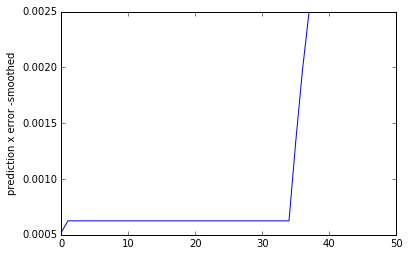

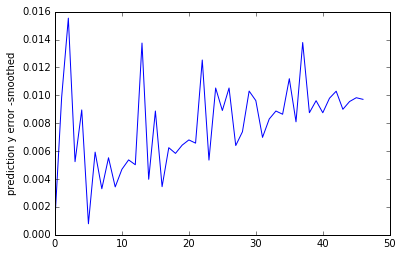

threshold: [ 0.01  0.01]
training error - score of impossible model: 1.0
test error - score of impossible model: 0.808510638298


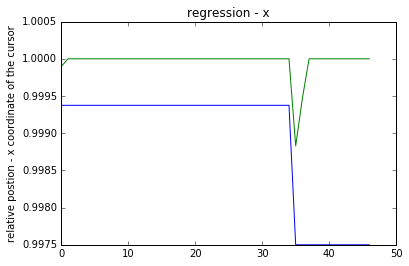

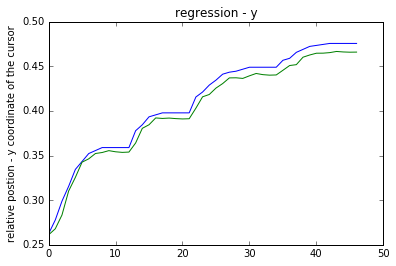

test - MSE: 0.0000731074
test - MSE - dist: 0.0160896678
test - smoothed MSE: 7.31073925823e-05
test - smoothed MSE per dist: 1.3061461374


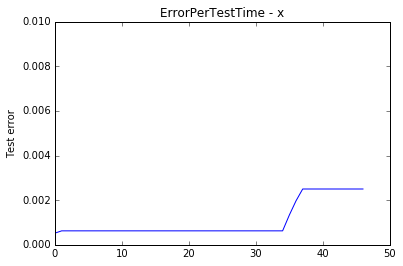

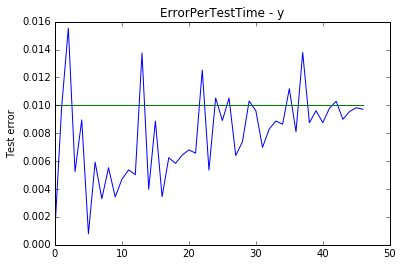

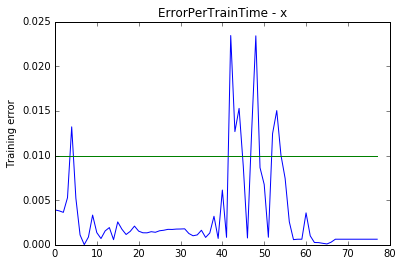

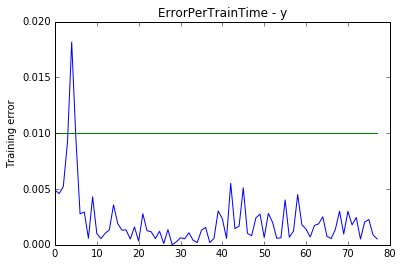

train - MSE: 0.0000471748
train - MSE - dist: 0.0057911615


In [280]:
current_number_features = 5

(model,imp_model,two_sigma) = generateModel(resource_path + "felix/felix_10sec_1",
                                  n_last_timestamps_as_features=current_number_features, v = True,
                                  stddev_factor = 0.01)

mean difference in time step: 0.03000475079


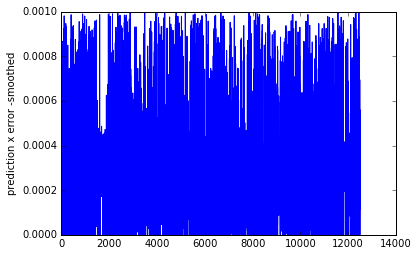

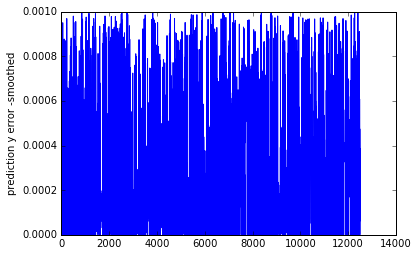

threshold: [ 0.001  0.001]
training error - score of impossible model: 0.632718991632
test error - score of impossible model: 0.623748899031


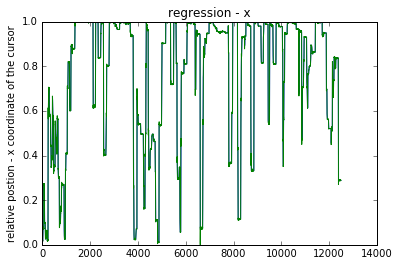

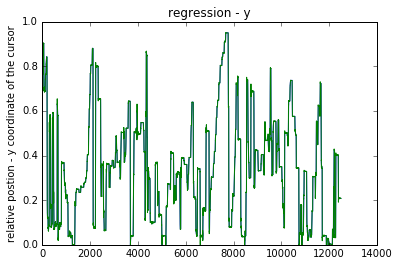

test - MSE: 0.0000782570
test - MSE - dist: 0.0183115660
test - smoothed MSE: 3.41967648207e-07
test - smoothed MSE per dist: 0.16829960174


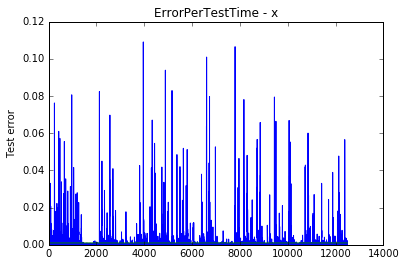

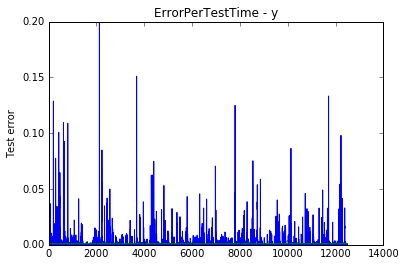

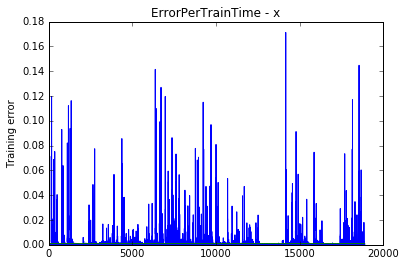

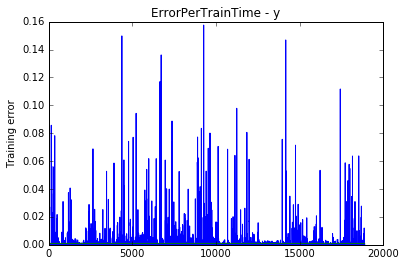

train - MSE: 0.0000786598
train - MSE - dist: 0.0220743910


In [330]:
current_number_features = 100

(model,imp_model,two_sigma) = generateModel(resource_path + "felix/felix_1h",
                                  n_last_timestamps_as_features=current_number_features, v = True,
                                  stddev_factor = 0.001)

Authorized user - test
mean difference in time step: 0.030002375188


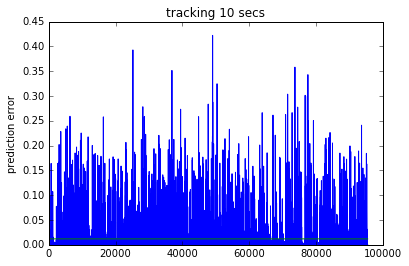

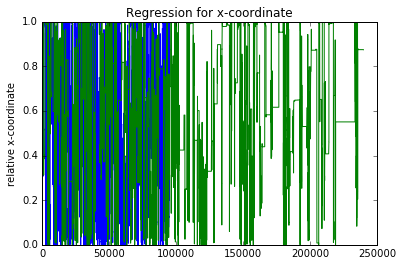

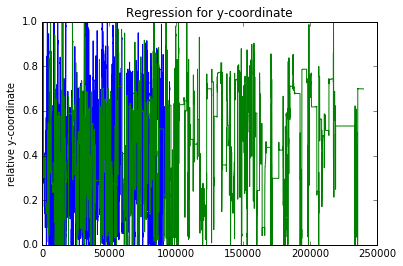

MSE per 0.03s: 0.000161758649086
MSE per pixel move: 0.0298823856473
number of records: 95309

max - |x+y|: 0.236920892183
max - squared: 0.056131509153
usable slots: 85004
smoothed MSE: 3.97493077171e-06
smoothed MSE per dist: 0.099972328154
This is Felix - Welcome to this awesome computer!


In [34]:
print ("Authorized user - test")
showStats(resource_path + "felix/felix_2h", model, imp_model, two_sigma, n_last_timestamps_as_features=current_number_features)

In [ ]:
#impact of number of features on accuracy

mseT = {}

endFeatures = 100

for i in np.arange(1,endFeatures,1):
    (fileX1, fileY1) = extractFeatures(resource_path + "felix/felix_1h", 
                                     n_last_timestamps_as_features = i, 
                                     normalize = True) 
    
    mseT[i] = generateModelData((fileX1, fileY1),n_last_timestamps_as_features = i, v = False, 
                                build_all_model = False)
    print mseT[i]
    
plt.plot(range(1, endFeatures), np.array(mseT.values(), dtype=float))
plt.ylabel('mean squared error')
plt.xlabel('number of features')
plt.show()

mean difference in time step: 0.03000475079
0.000107080753437
9.37452859732e-05
8.71437238137e-05
8.56322061918e-05
8.37051035438e-05
8.29384014329e-05
8.25208500063e-05
8.21742820317e-05
8.19850493831e-05
8.15633464322e-05


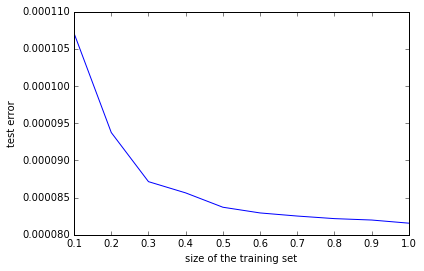

In [47]:
#impact of training size on accuracy

(fileX1, fileY1) = extractFeatures(resource_path + "felix/felix_1h", 
                                     n_last_timestamps_as_features = current_number_features, 
                                     normalize = True) 

mseT = {}

r = np.arange(1,11,1)

for i in r:
    mseT[i] = generateModelData((fileX1, fileY1), n_last_timestamps_as_features = current_number_features,
                                v = False, build_all_model = False, p_train_general = i * 0.1)
    print mseT[i]
    
plt.plot(r * 0.1, np.array(mseT.values(), dtype=float))
plt.ylabel('test error')
plt.xlabel('size of the training set')
plt.show()

mean difference in time step: 0.03000475079
3.41967648207e-07: 0.423893025863
8.7423486813e-07: 0.24541596605
1.47522476977e-06: 0.16758747698
2.03749480149e-06: 0.128433021059
2.61171313583e-06: 0.104652093843
3.20427580108e-06: 0.0875170149732
3.7875279345e-06: 0.0758267275202
4.2948606e-06: 0.0677396108576
4.84484063653e-06: 0.061414044359
5.42665496326e-06: 0.0558891824806
6.04555943595e-06: 0.0512450956842
6.6888578037e-06: 0.0470814316599
7.38281762974e-06: 0.0431579790215
8.07790657548e-06: 0.0399551605413
8.65064705127e-06: 0.0377131876051
9.41210731431e-06: 0.0349907918969
1.02058510918e-05: 0.0326687484987
1.1049012392e-05: 0.0303467051005
1.15653693334e-05: 0.0289855072464
1.24692458718e-05: 0.0270638161582
MSE


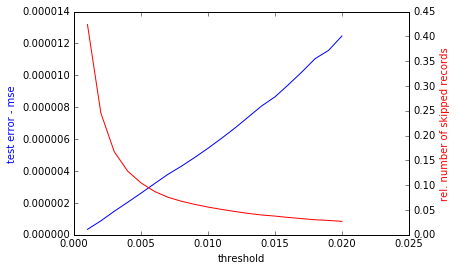

In [249]:
#smoothing effect on accuracy

(fileX1, fileY1) = extractFeatures(resource_path + "felix/felix_1h",  #"felix/felix_10sec_2" 
                                     n_last_timestamps_as_features = current_number_features, 
                                     normalize = True) 


error_time = {}
error_dist = {}
n_skipped = {}

r = np.arange(1,21,1)

step_size = 0.001

for i in r:
    (error_time[i], error_dist[i], n_smoothed) = generateModelData((fileX1, fileY1), 
                                                       n_last_timestamps_as_features = current_number_features, 
                                                       v = False, build_all_model = False, stddev_factor = i * step_size,
                                                       returnSmoothed = True)
    n_skipped[i] = 1.0 - n_smoothed
    print (str(error_time[i]) + ": " + str(n_skipped[i]))
    
print("MSE")
fig, ax1 = plt.subplots()   
ax1.plot(r * step_size, np.array(error_time.values(), dtype=float), color='b')
ax1.set_xlabel('threshold')
ax1.set_ylabel('test error - mse', color='b')

ax2 = ax1.twinx() 
ax2.plot(r * step_size, np.array(n_skipped.values(), dtype=float), color = 'r')
ax2.set_ylabel('rel. number of skipped records', color = 'r')
plt.show()



In [23]:
mseT_big = generateModelTest("felixtest2_7200sec_1",
                             n_last_timestamps_as_features=100, v = False, p_train_general = 0.5)
print mseT_big

mean difference in time step: 0.030002375188
(239882, 201)
0.000145509941413


Coefficients:


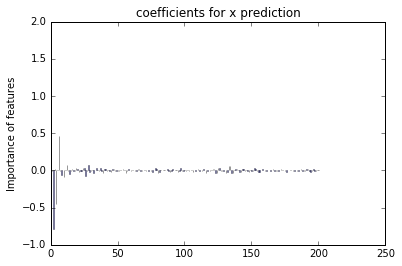

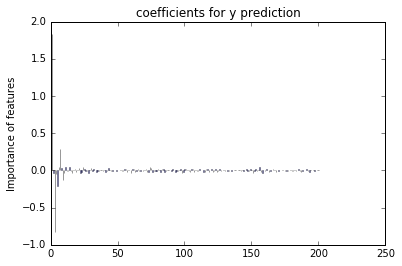

In [283]:
koef = np.asmatrix(model.coef_).A1

print('Coefficients:')

index = np.arange((len(koef)/2))
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

plt.bar(index, koef[0:(len(koef)/2)], bar_width, alpha=opacity, color='b')
plt.title('coefficients for x prediction')
plt.ylabel("Importance of features")
plt.show()

plt.bar(index, koef[(len(koef)/2):len(koef)], bar_width, alpha=opacity, color='b')
plt.title('coefficients for y prediction')
plt.ylabel("Importance of features")
plt.show()


Felix test1
mean difference in time step: 0.0300000000286
original shape: (234, 200)


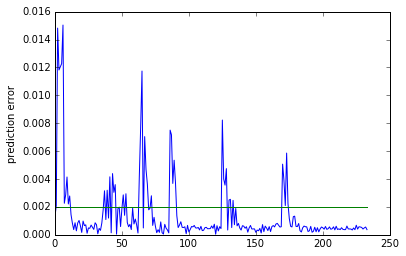

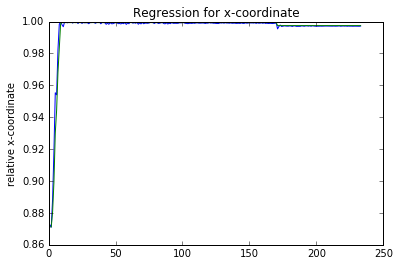

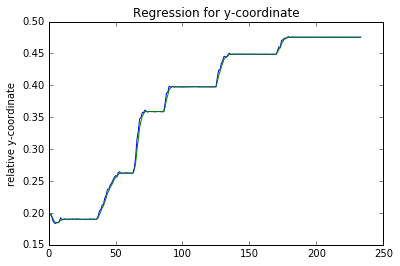

MSE per 0.03s: 6.16281270351e-06
MSE per pixel move: 0.0034550479332
number of records: 234

max - |x+y|: 0.0140761367078
max - squared: 0.000198137624617
smoothed MSE: 2.14566434299e-07
smoothed MSE per dist: 0.0941843860259
This is Felix - Welcome to this awesome computer!


In [357]:
print ("Felix test1")
showStats(resource_path + "felix/felix_10sec_1",model, imp_model, two_sigma, 
          n_last_timestamps_as_features=current_number_features)

Felix test2
mean difference in time step: 0.03003003003
original shape: (234, 200)


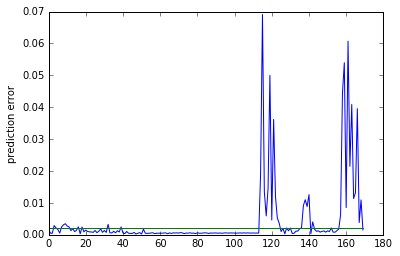

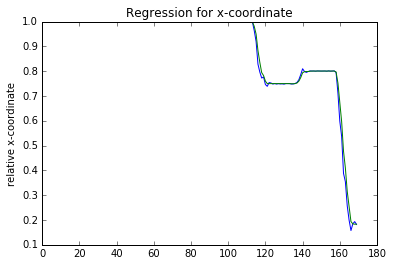

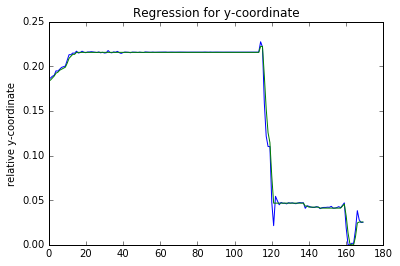

MSE per 0.03s: 9.37919554125e-05
MSE per pixel move: 0.0153991590721
number of records: 170

max - |x+y|: 0.0596023484721
max - squared: 0.00355243994339
smoothed MSE: 2.86409898452e-07
smoothed MSE per dist: 1.16696054962
This is Felix - Welcome to this awesome computer!


In [358]:
print ("Felix test2")
showStats(resource_path + "felix/felix_10sec_2",model, imp_model, two_sigma, n_last_timestamps_as_features=current_number_features)

Felix test3 - lying in bed
mean difference in time step: 0.0300000000286
original shape: (234, 200)


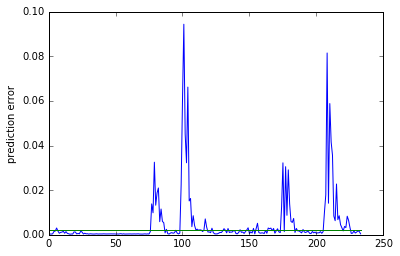

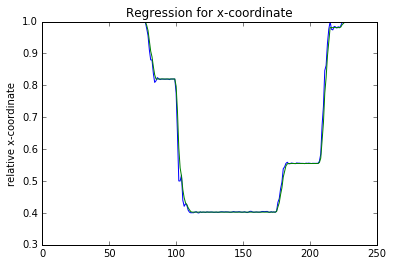

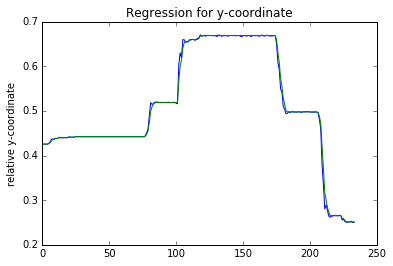

MSE per 0.03s: 0.000107498480085
MSE per pixel move: 0.0175073161298
number of records: 234

max - |x+y|: 0.0585860986895
max - squared: 0.00343233095965
smoothed MSE: 3.16054597706e-07
smoothed MSE per dist: 3.61250405178
This is Felix - Welcome to this awesome computer!


In [359]:
print ("Felix test3 - lying in bed")
showStats(resource_path + "felix/felix_10sec_3",model,imp_model, two_sigma, n_last_timestamps_as_features=current_number_features)

Felix test4
mean difference in time step: 0.0300000000286


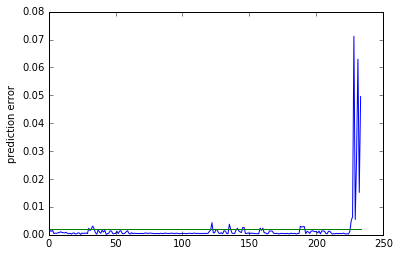

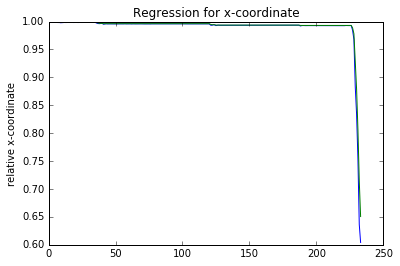

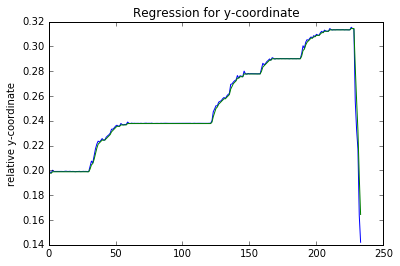

MSE per 0.03s: 3.1390663425e-05
MSE per pixel move: 0.0125563461912
number of records: 234

max - |x+y|: 0.0405277664897
max - squared: 0.00164249985664
smoothed MSE: 2.34891136707e-07
smoothed MSE per dist: 0.41932755776
This is Felix - Welcome to this awesome computer!


In [345]:
print ("Felix test4")
showStats(resource_path + "felix/felix_10sec_4",model, imp_model, two_sigma, n_last_timestamps_as_features=current_number_features)

Felix test5
mean difference in time step: 0.0300000000286


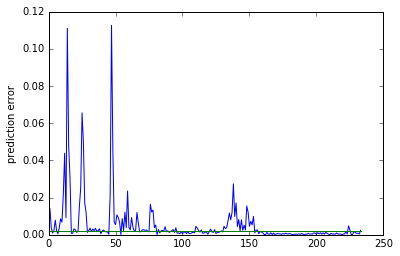

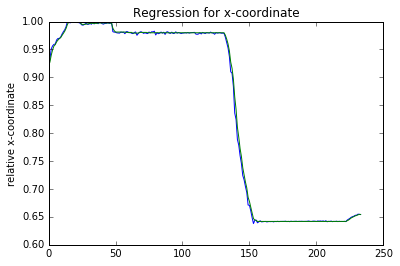

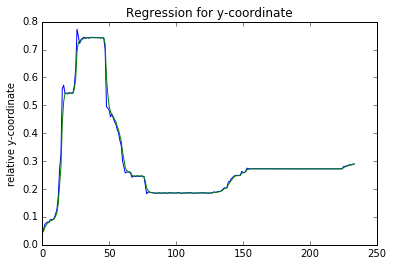

MSE per 0.03s: 0.000178357214742
MSE per pixel move: 0.0252477709264
number of records: 234

max - |x+y|: 0.110826472995
max - squared: 0.0122825071165
smoothed MSE: 3.0426566664e-07
smoothed MSE per dist: 0.146664796065
This is Felix - Welcome to this awesome computer!


In [346]:
print ("Felix test5")
showStats(resource_path + "felix/felix_10sec_5",model, imp_model, two_sigma, n_last_timestamps_as_features=current_number_features)

Niklas test1
mean difference in time step: 0.0300000000286


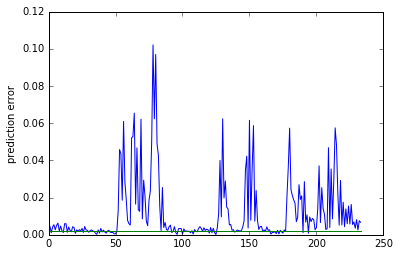

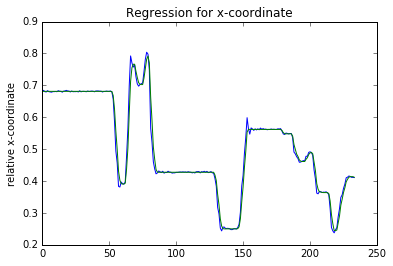

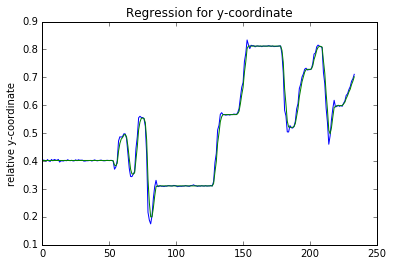

MSE per 0.03s: 0.000296348875549
MSE per pixel move: 0.0179435617065
number of records: 234

max - |x+y|: 0.0900139371297
max - squared: 0.00810250887759
smoothed MSE: 4.76762283176e-07
smoothed MSE per dist: 0.012557634561
This is not Felix - You are unauthorized!


In [347]:
print ("Niklas test1")
showStats(resource_path + "unauthorized/niklas_10sec",model, imp_model, two_sigma, n_last_timestamps_as_features=current_number_features)

Elias test1
mean difference in time step: 0.0300000000286


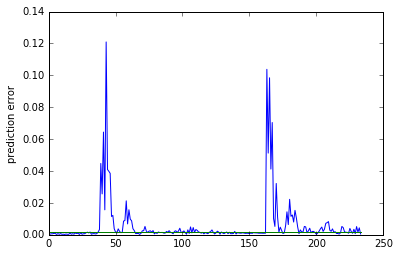

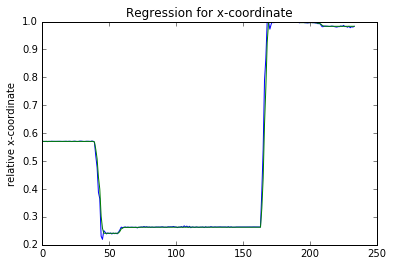

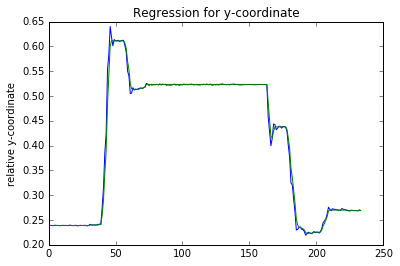

MSE per 0.03s: 0.000161725752777
MSE per pixel move: 0.0230468552586
number of records: 234

max - |x+y|: 0.0891744752982
max - squared: 0.00795208704471
smoothed MSE: 5.19316321266e-07
smoothed MSE per dist: 15.0030485214
This is not Felix - You are unauthorized!


In [348]:
print ("Elias test1")
showStats(resource_path + "unauthorized/elias_10sec",model, imp_model, two_sigma, n_last_timestamps_as_features=current_number_features)

Emely
mean difference in time step: 0.0300000000286


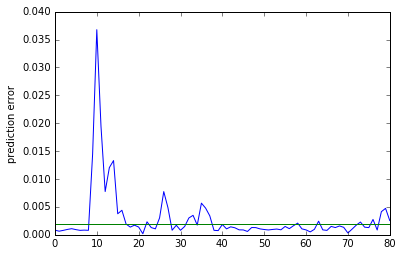

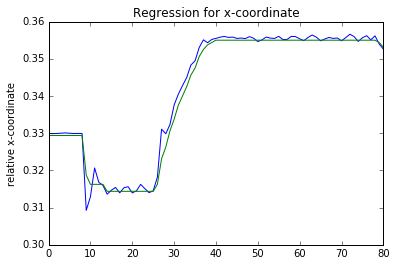

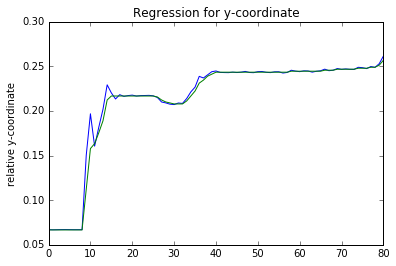

MSE per 0.03s: 2.51951639898e-05
MSE per pixel move: 0.00873998925479
number of records: 81

max - |x+y|: 0.0334226069166
max - squared: 0.0011170706531
smoothed MSE: 6.05397538903e-07
smoothed MSE per dist: 0.337540960505
This is not Felix - You are unauthorized!


In [349]:
print ("Emely")
showStats(resource_path + "unauthorized/emely_10sec", model, imp_model, two_sigma, n_last_timestamps_as_features=current_number_features)

Martin
mean difference in time step: 0.0300000000143
original shape: (1900, 200)


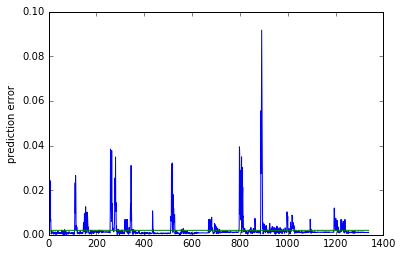

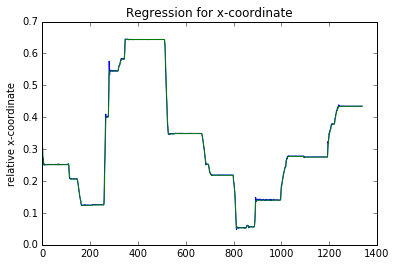

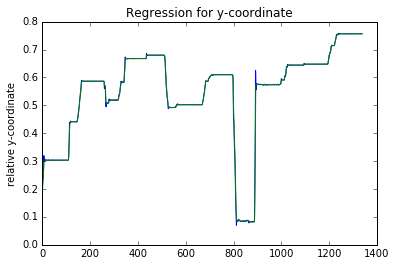

MSE per 0.03s: 2.75881019613e-05
MSE per pixel move: 0.0119106967232
number of records: 1339

max - |x+y|: 0.0755707077056
max - squared: 0.00571093186312
smoothed MSE: 5.62237084428e-07
smoothed MSE per dist: 0.241688359375
This is not Felix - You are unauthorized!


In [360]:
print ("Martin")
showStats(resource_path + "unauthorized/martin_60sec", model, imp_model, two_sigma, n_last_timestamps_as_features=current_number_features)

In [351]:
#mouse didn't move at all
print ("mouse didn't move at all")
showStats("nothing_10sec_1", model, imp_model, two_sigma, n_last_timestamps_as_features=current_number_features)

mouse didn't move at all


TypeError: showStats() takes at least 4 arguments (4 given)

In [ ]:
print ("test")
showStats("test_mouse", model, two_sigma, n_last_timestamps_as_features=2, normalize = False)

In [352]:
test_size = 234

In [355]:
(data, target) = extractFeatures(resource_path + "unauthorized/martin_60sec", 
                                 n_last_timestamps_as_features=current_number_features)

for i in range(data.shape[0] / test_size):
    fileX = data[(i*test_size):((i+1)*test_size),:]
    fileY = target[(i*test_size):((i+1)*test_size),:]

    showStatsData((fileX, fileY), model, imp_model, two_sigma, n_last_timestamps_as_features=current_number_features)

mean difference in time step: 0.0300000000143


ValueError: matrices are not aligned

In [832]:
test_size = 314

(data, target) = extractFeatures("felix_train", n_last_timestamps_as_features=current_number_features)

Ni = data.shape[0]
    
X_test = data[(Ni/2):Ni,:]
y_test = target[(Ni/2):Ni,:]

c1 = 0
c2 = 0

cc3 = 0

time_array = {}
dist_array = {}

threshold = np.array(two_sigma)

print data.shape

print (data.shape[0] / test_size)

for i in range(X_test.shape[0] / test_size):
    fileX = X_test[(i*test_size):((i+1)*test_size),:]
    fileY = y_test[(i*test_size):((i+1)*test_size),:]
    
    print ("vor: " + str(fileX.shape))
    
    (newData, newTarget) = getMovementsOnly(fileX, fileY) 
    
    print ("nach: " + str(len(newData)))
    
    if (len(newData) > 1):
        
        #distance
        dist = getDistance(newTarget)

        diff = np.absolute(model.predict(newData) - newTarget)

        N = newData.shape[0]

        newdist = getSmoothedDistance(newTarget, (diff[:,0] > threshold[0]), (diff[:,1] > threshold[1]))

        for l in range(len(diff)):
            change = False
            if (diff[l,0] > threshold[0]):
                diff[l,0] = 0
                change = True
            if (diff[l,1] > threshold[1]):
                diff[l,1] = 0
                change = True

            if (change): #if over threshold at x or y - check that
                N -= 1

        if (newdist > 0):
        
            time_error = np.sum(np.power(diff,2)) / N
            distance_error = np.sum(np.power(diff,2)) / newdist


            time_array[i] = time_error
            dist_array[i] = distance_error
            
            if (distance_error > 0.0024): #0.0024
                c1 += 1
            if (time_array > 0.0000081): #0.0000081
                c2 += 1
                
            '''
            if (distance_error > 0.00251):
                if (time_error > 0.0000081):
                    print ("number of slots - failed dist test: " + str(N))
                    print ("dist error: " + str(distance_error))
                    print ("time error: " + str(time_error))
                    cc3 +=1 
            '''
            
            #if (distance_error > 0.0032 or ( distance_error > 0.0019 and distance_error < 0.0032 and time_error > 0.00001)):
            if (distance_error > 0.11 or (distance_error < 0.11 and time_error > 0.00001)): 
            
                print ("number of slots - failed dist test: " + str(N))
                print ("dist error: " + str(distance_error))
                print ("time error: " + str(time_error))
                cc3 +=1 
    
        
print("bad count - dist measure: " + str(c1) + " of " + str(X_test.shape[0] / test_size))
print("bad count - time measure: " + str(c2) + " of " + str(X_test.shape[0] / test_size))
print("bad count - combined measure: " + str(cc3) + " of " + str(X_test.shape[0] / test_size))

print("\nmax time_error: " + str(np.max(time_array.values())) )
print("\nmax distance_error: " + str(np.max(dist_array.values())) )

mean difference in time step: 0.03000475079
(119881, 201)
(119881, 201)
381
vor: (314, 201)
nach: 0
vor: (314, 201)
nach: 0
vor: (314, 201)
nach: 0
vor: (314, 201)
nach: 0
vor: (314, 201)
nach: 0
vor: (314, 201)
nach: 0
vor: (314, 201)
nach: 0
vor: (314, 201)
nach: 0
vor: (314, 201)
nach: 0
vor: (314, 201)
nach: 0
vor: (314, 201)
nach: 0
vor: (314, 201)
nach: 0
vor: (314, 201)
nach: 0
vor: (314, 201)
nach: 0
vor: (314, 201)
nach: 184
number of slots - failed dist test: 160
dist error: 0.148463435385
time error: 5.96827252366e-06
vor: (314, 201)
nach: 0
vor: (314, 201)
nach: 0
vor: (314, 201)
nach: 0
vor: (314, 201)
nach: 0
vor: (314, 201)
nach: 97
number of slots - failed dist test: 91
dist error: 0.159880210434
time error: 3.41377822006e-06
vor: (314, 201)
nach: 41
vor: (314, 201)
nach: 0
vor: (314, 201)
nach: 0
vor: (314, 201)
nach: 109
number of slots - failed dist test: 106
dist error: 0.220128825494
time error: 1.54097068088e-06
vor: (314, 201)
nach: 0
vor: (314, 201)
nach: 0
vor: